Reading GPS trajectory data and converting in proper format for GIS analysis

In [2]:
import os
import pandas as pd

# Input and output directories
input_dir = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\DATA"
output_dir = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\1.GISinputcsv"

# Make sure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Walk through all subdirectories
for root, dirs, files in os.walk(input_dir):
    for file in files:
        # Process only Excel files
        if file.endswith((".xls", ".xlsx")):
            file_path = os.path.join(root, file)
            try:
                # Read Excel file with header at row 7 (0-indexed, so header=7 reads the 8th row)
                df = pd.read_excel(file_path, header=7)
                
                # Create CSV file path
                csv_filename = os.path.splitext(file)[0] + ".csv"
                csv_path = os.path.join(output_dir, csv_filename)
                
                # Save as CSV
                df.to_csv(csv_path, index=False)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")


**GIS Analysis:**
**Processing steps (for each CSV file):**
1. **Create point layer**  
   - Uses Longitude & Latitude columns  
   - CRS: EPSG:4326 (WGS84)  
   - Saves points as a new layer in `day5.gpkg`

2. **Join with route buffer** (`Dissolvedbuffer`)  
   - Spatial join (intersect/contain)  
   - Adds field `Inside_Route` (1 = inside route, null/0 = outside)  
   - Output layer: `{filename}_insideroute`

3. **Join with segment/stop buffers** (`segment_buffer`)  
   - Spatial join (intersect/contain)  
   - Adds fields: `Description` (bus stop name) and `Segment_point` (segment ID)  
   - Final output: CSV file in `2.GIS result/{filename}_gis.csv`
     
**Output files:**
Contains: original columns + Inside_Route + Description + Segment_point

In [ ]:
import os

directory = "C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\1.GISinputcsv"
files_name = [file for file in os.listdir(directory) if file.endswith('.csv')]

for file in files_name:
    file_withoutspace = file.replace(" ","")
    file_withoutcsv = file.replace(".csv","")

    # 3622 jan_result
    processing.run("native:createpointslayerfromtable", {'INPUT':f'C:/Users/ACER/Desktop/PROJECT-FINAL YEAR/Dataextraction/1.GISinputcsv/{file}','XFIELD':'Longitude','YFIELD':'Latitude','ZFIELD':'','MFIELD':'','TARGET_CRS':QgsCoordinateReferenceSystem('EPSG:4326'),'OUTPUT':f'ogr:dbname=\'C:/Users/ACER/Desktop/PROJECT-FINAL YEAR/GIS_analysis/day5.gpkg\' table="{file_withoutcsv}" (geom)'})

    processing.run("native:joinattributesbylocation", {'INPUT':f'C:/Users/ACER/Desktop/PROJECT-FINAL YEAR/GIS_analysis/day5.gpkg|layername={file_withoutcsv}','PREDICATE':[5],'JOIN':'C:/Users/ACER/Desktop/PROJECT-FINAL YEAR/GIS_analysis/day1.gpkg|layername=Dissolvedbuffer','JOIN_FIELDS':['Inside_Route'],'METHOD':1,'DISCARD_NONMATCHING':False,'PREFIX':'','OUTPUT':f'ogr:dbname=\'C:/Users/ACER/Desktop/PROJECT-FINAL YEAR/GIS_analysis/day5.gpkg\' table="{file_withoutcsv}_insideroute" (geom)'})

    processing.run("native:joinattributesbylocation", {'INPUT':f'C:/Users/ACER/Desktop/PROJECT-FINAL YEAR/GIS_analysis/day5.gpkg|layername={file_withoutcsv}_insideroute','PREDICATE':[5],'JOIN':f'C:/Users/ACER/Desktop/PROJECT-FINAL YEAR/GIS_analysis/day5.gpkg|layername=segment_buffer','JOIN_FIELDS':['Description','Segment_point'],'METHOD':1,'DISCARD_NONMATCHING':False,'PREFIX':'','OUTPUT':f'C:/Users/ACER/Desktop/PROJECT-FINAL YEAR/Dataextraction/2.GIS result/{file_withoutcsv}_gis.csv'})
    print(f"complete {file}")

### Travel Time Calculation (Lagankhel ↔ Budhanilkantha)

This section identifies **complete one-way trips** and calculates their **travel duration** in minutes.

**Logic summary:**
- **Forward** (Lagankhel → Budhanilkantha): starts near segment 1 → ends at segment 8
- **Backward** (Budhanilkantha → Lagankhel): starts near segment 8 → ends at segment 1
- Only daytime trips (05:00–22:00) are considered
- Only **complete** trips (terminal to terminal) are kept

**Output:**
- Separate Excel files for each direction
- Columns: `Departure Time`, `Arrival Time`, `Travel Time(min)`

In [9]:
import os
import glob
import pandas as pd
import numpy as np

# -----------------------------
# INPUT & OUTPUT PATHS
# -----------------------------
input_folder = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\2.GIS result'

# Correct folder names exactly as requested
output_Lagankhel_Budhanilkantha = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\3.Duration_extraction\Lagankhel-Budhanilkantha\Lagankhel-Budhanilkantha'
output_Budhanilkantha_Lagankhel = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\3.Duration_extraction\Budhanilkantha-Lagankhel\Budhanilkantha-Lagankhel'

# Create folders if they don't exist
os.makedirs(output_Lagankhel_Budhanilkantha, exist_ok=True)
os.makedirs(output_Budhanilkantha_Lagankhel, exist_ok=True)

# Get all CSV files
file_paths = glob.glob(os.path.join(input_folder, '*.csv'))

# -----------------------------
# PROCESS EACH FILE
# -----------------------------
for file in file_paths:

    # Read required columns only
    df = pd.read_csv(file, encoding='unicode_escape', usecols=["Time", "Inside_Route",  "Description", "Segment_point"])

    # Convert Time to datetime & sort
    df["Time"] = pd.to_datetime(df["Time"])
    # Filter rows between 5 AM and 10 PM
    df = df[(df['Time'].dt.time >= pd.to_datetime('05:00:00').time()) & 
            (df['Time'].dt.time <= pd.to_datetime('22:00:00').time())]
    df = df.sort_values("Time").reset_index(drop=True)

    trips = []
    in_trip = False
    start_time = None
    start_point = None
    prev_segment = np.nan

    # -----------------------------
    # MAIN LOOP (state-based)
    # -----------------------------
    for _, row in df.iterrows():

        if row["Inside_Route"] == 0:
            prev_segment = row["Segment_point"]
            continue

        current_segment = row["Segment_point"]

        # START CONDITION
        if not in_trip:
            if prev_segment in [1, 8] and pd.isna(current_segment):
                in_trip = True
                start_time = row["Time"]
                start_point = prev_segment

        # END CONDITION
        else:
            if start_point == 1 and current_segment == 8:
                trips.append([start_time, row["Time"], "Lagankhel-Budhanilkantha"])
                in_trip = False

            elif start_point == 8 and current_segment == 1:
                trips.append([start_time, row["Time"], "Budhanilkantha-Lagankhel"])
                in_trip = False

        prev_segment = current_segment

    # -----------------------------
    # CREATE OUTPUT DATAFRAME
    # -----------------------------
    trips_df = pd.DataFrame(
        trips,
        columns=["Departure Time", "Arrival Time", "Direction"]
    )

    if trips_df.empty:
        continue

    trips_df["Travel Time(min)"] = (
        trips_df["Arrival Time"] - trips_df["Departure Time"]
    ).dt.total_seconds() / 60

    # -----------------------------
    # SPLIT BY DIRECTION
    # -----------------------------
    df_LB = trips_df[trips_df["Direction"] == "Lagankhel-Budhanilkantha"].drop(columns="Direction")
    df_BL = trips_df[trips_df["Direction"] == "Budhanilkantha-Lagankhel"].drop(columns="Direction")

    base_name = os.path.splitext(os.path.basename(file))[0]

    # -----------------------------
    # SAVE OUTPUT FILES
    # -----------------------------
    if not df_LB.empty:
        df_LB.to_excel(
            os.path.join(output_Lagankhel_Budhanilkantha, f"{base_name}.xlsx"),
            index=False
        )

    if not df_BL.empty:
        df_BL.to_excel(
            os.path.join(output_Budhanilkantha_Lagankhel, f"{base_name}.xlsx"),
            index=False
        )


C:\Users\ACER\AppData\Local\Temp\ipykernel_22960\1632724631.py:28: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='unicode_escape', usecols=["Time", "Inside_Route",  "Description", "Segment_point"])


### Segment-level Travel Time Extraction  
(Adjacent Segments Only – Forward & Reverse)

This section detects **short trips between adjacent segments** only and calculates their travel duration.

**Key segments (in order):**
1 → Lagankhel  
3 → Kupondole  
5 → Lazimpat  
7 → Gangalal  
8 → Budhanilkantha  

**Detected segment pairs (only adjacent):**
- Forward: 1→3, 3→5, 5→7, 7→8  
- Reverse: 3→1, 5→3, 7→5, 8→7

**Output structure:**

Each folder contains `.xlsx` files with columns:  
`Departure Time` • `Arrival Time` • `Travel Time(min)`

In [10]:
import pandas as pd
import numpy as np
import os
import glob

# -----------------------------
# PATHS
# -----------------------------
input_folder = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\2.GIS result'

forward_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\3.Duration_extraction\Lagankhel-Budhanilkantha'
reverse_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\3.Duration_extraction\Budhanilkantha-Lagankhel'

# Segment order and mapping
segment_order = [1, 3, 5, 7, 8]
segment_map = {
    1: "Lagankhel",
    3: "Kupondole",
    5: "Lazimpat",
    7: "Gangalal",
    8: "Budhanilkantha"
}

# Create output folders for adjacent segments only (with names)
for i in range(len(segment_order) - 1):
    forward_name = f"{segment_map[segment_order[i]]}-{segment_map[segment_order[i+1]]}"
    reverse_name = f"{segment_map[segment_order[i+1]]}-{segment_map[segment_order[i]]}"
    os.makedirs(os.path.join(forward_base, forward_name), exist_ok=True)
    os.makedirs(os.path.join(reverse_base, reverse_name), exist_ok=True)

# Create allowed segment pairs (adjacent only)
allowed_pairs = set()
for i in range(len(segment_order)-1):
    # forward
    allowed_pairs.add((segment_order[i], segment_order[i+1]))
    # reverse
    allowed_pairs.add((segment_order[i+1], segment_order[i]))

# -----------------------------
# PROCESS FILES
# -----------------------------
file_paths = glob.glob(os.path.join(input_folder, '*.csv'))


for file in file_paths:

    # Read required columns only
    df = pd.read_csv(file, encoding='unicode_escape',
                     usecols=["Time", "Inside_Route", "Description", "Segment_point"], low_memory=False)

    # Convert Time to datetime & sort
    df["Time"] = pd.to_datetime(df["Time"])
    # Filter rows between 5 AM and 10 PM
    df = df[(df['Time'].dt.time >= pd.to_datetime('05:00:00').time()) & 
            (df['Time'].dt.time <= pd.to_datetime('22:00:00').time())]
    df = df.sort_values("Time").reset_index(drop=True)

    trips = []
    in_trip = False
    start_time = None
    start_segment = None
    prev_segment = np.nan

    for _, row in df.iterrows():

        if row["Inside_Route"] == 0:
            prev_segment = np.nan
            in_trip = False
            continue

        current_segment = row["Segment_point"]

        # START
        if not in_trip:
            if prev_segment in segment_order and pd.isna(current_segment):
                in_trip = True
                start_time = row["Time"]
                start_segment = prev_segment

        # END
        else:
            if current_segment in segment_order and current_segment != start_segment:
                # Only allow adjacent pairs
                if (start_segment, current_segment) in allowed_pairs:
                    trips.append([start_time, row["Time"], start_segment, current_segment])
                in_trip = False

        prev_segment = current_segment

    # -----------------------------
    # CREATE OUTPUT
    # -----------------------------
    trips_df = pd.DataFrame(
        trips,
        columns=["Departure Time", "Arrival Time", "Start", "End"]
    )

    if trips_df.empty:
        continue

    trips_df["Travel Time(min)"] = (
        trips_df["Arrival Time"] - trips_df["Departure Time"]
    ).dt.total_seconds() / 60

    base_name = os.path.splitext(os.path.basename(file))[0]

    # -----------------------------
    # SAVE FILES
    # -----------------------------
    for _, r in trips_df.iterrows():

        # Map segment numbers to names
        start_name = segment_map[int(r['Start'])]
        end_name = segment_map[int(r['End'])]
        seg_name = f"{start_name}-{end_name}"

        # Forward adjacent segment
        if (r['Start'], r['End']) in allowed_pairs and r['Start'] < r['End']:
            out_dir = os.path.join(forward_base, seg_name)

        # Reverse adjacent segment
        elif (r['Start'], r['End']) in allowed_pairs and r['Start'] > r['End']:
            out_dir = os.path.join(reverse_base, seg_name)

        else:
            # Skip non-adjacent segments
            continue

        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, f"{base_name}.xlsx")

        # Append if file exists
        if os.path.exists(out_path):
            existing = pd.read_excel(out_path)
            combined = pd.concat([existing, pd.DataFrame([r.drop(['Start','End'])])], ignore_index=True)
        else:
            combined = pd.DataFrame([r.drop(['Start','End'])])

        combined.to_excel(out_path, index=False)


### Half-Hourly Sorting of Travel Times

This section takes all travel time records from each segment/direction and **groups them into half-hourly intervals** based on **Departure Time**.

**Purpose:**  
Organize trip data into separate worksheets inside one Excel file per segment, making it easier to analyze patterns by time of day.

**Time range:** 06:00 – 20:00  
**Intervals:** 30-minute bins  
Examples of sheets: `06_00-06_30`, `06_30-07_00`, `07_00-07_30`, ..., `19_30-20_00`

**Input:**  
All `.xlsx` files from each segment folder (e.g. `Lagankhel-Kupondole/`, `Kupondole-Lazimpat/`, etc.)

**Output structure:**
Each Excel file contains multiple sheets — one for each half-hour interval  
(with trips sorted by departure time)

In [4]:
import os
import pandas as pd
import glob
from datetime import time

# ---------------------------------
# PATHS
# ---------------------------------
input_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\3.Duration_extraction'
output_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\4.half_hourly_sorted'

# Top-level folders renamed to your desired style
forward_out = os.path.join(output_base, 'Lagankhel-Budhanilkantha')
reverse_out = os.path.join(output_base, 'Budhanilkantha-Lagankhel')

os.makedirs(forward_out, exist_ok=True)
os.makedirs(reverse_out, exist_ok=True)

# ---------------------------------
# SEGMENTS (using names)
# ---------------------------------
# Mapping: 1=Lagankhel, 3=Kupondole, 5=Lazimpat, 7=Gangalal, 8=Budhanilkantha
forward_segments = [
    'Lagankhel-Kupondole',
    'Kupondole-Lazimpat',
    'Lazimpat-Gangalal',
    'Gangalal-Budhanilkantha',
    'Lagankhel-Budhanilkantha'
]

reverse_segments = [
    'Kupondole-Lagankhel',
    'Lazimpat-Kupondole',
    'Gangalal-Lazimpat',
    'Budhanilkantha-Gangalal',
    'Budhanilkantha-Lagankhel'
]

# ---------------------------------
# HALF-HOUR BINS
# ---------------------------------
def generate_half_hour_bins(start=time(6,0), end=time(20,0)):
    bins = []
    h, m = start.hour, start.minute

    while (h < end.hour) or (h == end.hour and m < end.minute):
        start_t = time(h, m)
        if m == 0:
            end_t = time(h, 30)
            m = 30
        else:
            end_t = time(h + 1, 0)
            h += 1
            m = 0
        bins.append((start_t, end_t))
    return bins

time_bins = generate_half_hour_bins()

# ---------------------------------
# PROCESS FUNCTION
# ---------------------------------
def process_segments(segment_list, source_root, output_root):

    for seg in segment_list:

        source_folder = os.path.join(source_root, seg)
        files = glob.glob(os.path.join(source_folder, '*.xlsx'))
        if not files:
            continue

        all_data = []
        for f in files:
            df = pd.read_excel(f)
            df['Departure Time'] = pd.to_datetime(df['Departure Time'])
            all_data.append(df)

        data = pd.concat(all_data, ignore_index=True)

        out_path = os.path.join(output_root, f'{seg}.xlsx')

        with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
            for start_t, end_t in time_bins:

                mask = (
                    (data['Departure Time'].dt.time >= start_t) &
                    (data['Departure Time'].dt.time < end_t)
                )

                chunk = data.loc[mask].sort_values('Departure Time')

                sheet = f"{start_t.strftime('%H_%M')}-{end_t.strftime('%H_%M')}"
                if not chunk.empty:
                    chunk.to_excel(writer, sheet_name=sheet, index=False)

        # print(f"Saved: {out_path}")

# ---------------------------------
# RUN
# ---------------------------------
process_segments(forward_segments,
                 source_root=os.path.join(input_base, 'Lagankhel-Budhanilkantha'),
                 output_root=forward_out)

process_segments(reverse_segments,
                 source_root=os.path.join(input_base, 'Budhanilkantha-Lagankhel'),
                 output_root=reverse_out)

print("Half-hour sorting completed.")


Half-hour sorting completed.


### Holiday & Outlier Removal

This section cleans the half-hourly sorted travel time data by removing:

- All trips that occurred on **Saturdays** (weekend in Nepal)
- Any trips with unrealistic duration (**> 5 hours**)

**Purpose:**  
Exclude non-working days (Saturdays) and obvious data errors/outliers to improve analysis quality for typical weekday patterns.

**Input:**  
Excel files from half-hourly sorted folders (each containing multiple time-bin sheets)

**Output structure:**
 Half-hourly Excel files → Same structure, but filtered

In [5]:
import os
import pandas as pd
import glob

# -----------------------------------
# PATHS
# -----------------------------------
input_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\4.half_hourly_sorted'
output_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\5.holiday_removed'

# Directions using place names
directions = ['Lagankhel-Budhanilkantha', 'Budhanilkantha-Lagankhel']

# Create output folders
for d in directions:
    os.makedirs(os.path.join(output_base, d), exist_ok=True)

# -----------------------------------
# PROCESS FILES
# -----------------------------------
for direction in directions:

    in_dir = os.path.join(input_base, direction)
    out_dir = os.path.join(output_base, direction)

    files = glob.glob(os.path.join(in_dir, '*.xlsx'))

    for file in files:

        xls = pd.ExcelFile(file)
        output_path = os.path.join(out_dir, os.path.basename(file))

        with pd.ExcelWriter(output_path, engine='openpyxl') as writer:

            for sheet in xls.sheet_names:
                df = pd.read_excel(xls, sheet_name=sheet)

                # Ensure datetime
                df['Departure Time'] = pd.to_datetime(df['Departure Time'])

                # Remove Saturday (Monday=0, Saturday=5)
                df = df[df['Departure Time'].dt.dayofweek != 5]
                # Remove trips longer than 5 hours
                df = df[(df['Travel Time(min)'] <= 5 * 60)]

                # Write back (even if empty, to preserve structure)
                df.to_excel(writer, sheet_name=sheet, index=False)

        # print(f"Processed (Saturday removed): {output_path}")

print("Holiday and outlier removal completed.")


Holiday and outlier removal completed.


### Distribution Fitting & Goodness-of-Fit Analysis  
(Travel Time Distributions per Time Interval)

**Purpose**  
This section evaluates which probability distribution best describes the **travel time data** in each 30-minute time bin, for every segment and direction.

Travel times in urban traffic are typically **right-skewed** (long tail of unusually long trips due to congestion, incidents, signals, etc.).  
Therefore, common skewed distributions are tested instead of assuming normality.

**Distributions compared:**
| Distribution   | Parameters fitted       | Typical use in traffic                          | Shape flexibility |
|----------------|--------------------------|--------------------------------------------------|-------------------|
| Log-Normal     | shape, scale (loc=0)    | Most widely used for travel times                | High             |
| Gamma          | shape, scale (loc=0)    | Flexible, often good for moderate skewness       | High             |
| Weibull        | shape, scale (loc=0)    | Used in reliability engineering & some traffic   | Medium–High      |
| Exponential    | scale (loc=0)           | Memoryless — assumes no learning/improvement     | Low (only one shape) |

**Key statistical test used:**  
**Anderson–Darling (A-D) goodness-of-fit test**  
- Sensitive to deviations in both tails (especially important for right-skewed data)  
- Lower A-D statistic = better fit  
- Critical value at α = 0.05 level used for decision  
  → If A-D ≤ critical value → **Pass** (distribution is acceptable at 5% significance)  
  → Otherwise → **Fail**

**Critical values used (approximate for large samples):**
- Log-Normal : 0.795  
- Gamma      : 0.752  
- Weibull    : 0.474  
- Exponential: 1.321  

**What is calculated for each distribution & each time interval:**
- Mean & Standard Deviation (empirical)
- Fitted parameters (shape & scale)
- Percentiles: 15th, 50th (median), 95th
- Anderson–Darling test statistic
- Pass/Fail result at 5% significance level

**Visual output:**  
For each time interval → Histogram of actual travel times + overlaid PDF curves of all four fitted distributions  
→ Helps visually judge which distribution follows the data most closely

**Output structure:**
For each segment and direction, a dedicated folder is created containing:

- `distribution_fitting_results.xlsx`  
  → One sheet per distribution (Log-Normal, Weibull, Gamma, Exponential) with fitted parameters, percentiles, A-D statistics, and pass/fail results.

- `Histograms/` subfolder  
  → One PNG file per time interval (e.g. `06_00-06_30.png`, `06_30-07_00.png`, …) showing the histogram of travel times overlaid with the fitted PDF curves of all four distributions.

**Interpretation guide:**
- If **Log-Normal** consistently passes and has the lowest A-D value → confirms it is usually the best theoretical model for travel times (very common finding in literature)
- If **Weibull** or **Gamma** performs better in some intervals → indicates different skewness or tail behavior (possible presence of multimodal effects or incidents)
- **Exponential** almost never fits well (too light-tailed) — used mainly as a baseline
- Visual inspection of histograms is very important — numerical test alone can be misleading with small sample sizes

In [2]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Main input and output directories
input_base = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\5.holiday_removed"
output_base = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Distribution_fitting"

distributions = ['Log-Normal', 'Exponential', 'Gamma', 'Weibull']

CRITICAL_VALUES = {
    'Log-Normal': {0.05: 0.795},
    'Exponential': {0.05: 1.321},
    'Gamma': {0.05: 0.752},
    'Weibull': {0.05: 0.474}
}

def compute_ad_stat(data, cdf_func, *params):
    n = len(data)
    sorted_data = np.sort(data)
    cdf_vals = cdf_func(sorted_data, *params)
    epsilon = 1e-10
    cdf_vals = np.clip(cdf_vals, epsilon, 1 - epsilon)
    ad_stat = -n - np.sum((2 * np.arange(1, n + 1) - 1) *
                          (np.log(cdf_vals) + np.log(1 - cdf_vals[::-1]))) / n
    return ad_stat

def check_ad_test(ad_stat, distribution):
    crit_5 = CRITICAL_VALUES[distribution][0.05]
    return "Pass (5%)" if ad_stat <= crit_5 else "Fail"

# Loop through all Excel files in subfolders
for root, dirs, files in os.walk(input_base):
    for file in files:
        if file.endswith('.xlsx') or file.endswith('.xls'):
            input_file = os.path.join(root, file)
            
            # Determine parent folder name and file name without extension
            parent_folder = os.path.basename(root)
            file_name_no_ext = os.path.splitext(file)[0]
            
            # Output folder: Distribution_fitting\ParentFolder\FileName
            output_folder = os.path.join(output_base, parent_folder, file_name_no_ext)
            os.makedirs(output_folder, exist_ok=True)
            
            # Histogram folder inside output folder
            hist_folder = os.path.join(output_folder, 'Histograms')
            os.makedirs(hist_folder, exist_ok=True)
            
            # Read Excel file
            xls = pd.ExcelFile(input_file)
            sheet_names = xls.sheet_names
            results = {dist: [] for dist in distributions}
            
            for sheet in sheet_names:
                df = pd.read_excel(xls, sheet_name=sheet)
                travel_times = df.iloc[:, 2].dropna().values
                travel_times = travel_times[travel_times > 0]
                if len(travel_times) < 2:
                    continue
                
                # Fit distributions
                shape_ln, loc_ln, scale_ln = stats.lognorm.fit(travel_times, floc=0)
                shape_wb, loc_wb, scale_wb = stats.weibull_min.fit(travel_times, floc=0)
                shape_gm, loc_gm, scale_gm = stats.gamma.fit(travel_times, floc=0)
                scale_exp = stats.expon.fit(travel_times, floc=0)[1]

                # Percentiles
                percentiles = [15, 50, 95]
                ln_perc = stats.lognorm.ppf(np.array(percentiles) / 100, shape_ln, loc=loc_ln, scale=scale_ln)
                wb_perc = stats.weibull_min.ppf(np.array(percentiles) / 100, shape_wb, loc=loc_wb, scale=scale_wb)
                gm_perc = stats.gamma.ppf(np.array(percentiles) / 100, shape_gm, loc=loc_gm, scale=scale_gm)
                exp_perc = stats.expon.ppf(np.array(percentiles) / 100, loc=0, scale=scale_exp)

                # A-D stats
                ad_ln = compute_ad_stat(travel_times, stats.lognorm.cdf, shape_ln, loc_ln, scale_ln)
                ad_wb = compute_ad_stat(travel_times, stats.weibull_min.cdf, shape_wb, loc_wb, scale_wb)
                ad_gm = compute_ad_stat(travel_times, stats.gamma.cdf, shape_gm, loc_gm, scale_gm)
                ad_exp = compute_ad_stat(travel_times, stats.expon.cdf, 0, scale_exp)

                # Append results
                results['Log-Normal'].append([sheet, np.mean(travel_times), np.std(travel_times),
                                              shape_ln, scale_ln, *ln_perc, ad_ln, check_ad_test(ad_ln, 'Log-Normal')])
                results['Weibull'].append([sheet, np.mean(travel_times), np.std(travel_times),
                                           shape_wb, scale_wb, *wb_perc, ad_wb, check_ad_test(ad_wb, 'Weibull')])
                results['Gamma'].append([sheet, np.mean(travel_times), np.std(travel_times),
                                         shape_gm, scale_gm, *gm_perc, ad_gm, check_ad_test(ad_gm, 'Gamma')])
                results['Exponential'].append([sheet, np.mean(travel_times), np.std(travel_times),
                                               None, scale_exp, *exp_perc, ad_exp, check_ad_test(ad_exp, 'Exponential')])

                # Plot histogram
                x = np.linspace(min(travel_times), max(travel_times), 100)
                plt.hist(travel_times, bins=20, density=True, alpha=0.6, color='gray', label='Data')
                plt.plot(x, stats.lognorm.pdf(x, shape_ln, loc_ln, scale_ln), label='Log-Normal', linestyle='--')
                plt.plot(x, stats.expon.pdf(x, 0, scale_exp), label='Exponential', linestyle='--')
                plt.plot(x, stats.gamma.pdf(x, shape_gm, loc_gm, scale_gm), label='Gamma', linestyle='--')
                plt.plot(x, stats.weibull_min.pdf(x, shape_wb, loc_wb, scale_wb), label='Weibull', linestyle='--')
                plt.xlabel('Travel Time (min)')
                plt.ylabel('Density')
                plt.title(f'Distribution Fit - {sheet}')
                plt.legend()
                plt.savefig(os.path.join(hist_folder, f'{sheet}.png'))
                plt.close()

            # Save results to Excel
            output_file = os.path.join(output_folder, 'distribution_fitting_results.xlsx')
            with pd.ExcelWriter(output_file) as writer:
                for dist in distributions:
                    columns = ['Time Interval', 'Mean', 'Std Dev', 'Shape', 'Scale',
                               '15th Perc', '50th Perc', '95th Perc', 'A-D Stat', 'Pass/Fail']
                    df_out = pd.DataFrame(results[dist], columns=columns)
                    df_out.to_excel(writer, sheet_name=dist, index=False)

print(f"All files saved")


All files saved


### Final Distribution Comparison Summary  
(Best-Fitting Distribution Across All Time Intervals)

This section aggregates results from all `distribution_fitting_results.xlsx` files and answers two key questions for each segment:

**1. Cases Pass (%)**  
→ What percentage of time intervals (30-min bins) does the distribution **pass the Anderson–Darling test at 5% significance**?  
(i.e., can be considered an acceptable fit)

**2. Cases 1st (%)**  
→ In what percentage of time intervals does the distribution have the **lowest A-D statistic** (best numerical fit) compared to the other three?

**Distributions evaluated:**  
- Log-Normal  
- Exponential  
- Gamma  
- Weibull  

**Output**  
A new file `distribution_analysis.xlsx` is created in each segment folder containing one simple table:

| Distribution  | Cases Pass (%) | Cases 1st (%)         |
|---------------|----------------|------------------------|
| Log-Normal    | e.g. 96.4%     | e.g. 78.6% (most often best) |
| Gamma         | ...            | ...                    |
| Weibull       | ...            | ...                    |
| Exponential   | ...            | ...                    |

**Purpose & Interpretation**  
- **Highest "Cases 1st (%)"** → the most frequently best-fitting distribution (winner overall)  
- **Highest "Cases Pass (%)"** → the most consistently acceptable model

In [3]:
import os
import pandas as pd

# Base folder where all distribution_fitting results are stored
base_folder = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Distribution_fitting"

# Sheet names
distributions = ["Log-Normal", "Exponential", "Gamma", "Weibull"]

# Walk through all subfolders
for root, dirs, files in os.walk(base_folder):
    if "distribution_fitting_results.xlsx" in files:
        input_file = os.path.join(root, "distribution_fitting_results.xlsx")
        
        # Read all sheets
        data = {sheet: pd.read_excel(input_file, sheet_name=sheet) for sheet in distributions}
        total_cases = len(data[distributions[0]])  # assuming all sheets have same number of rows
        
        results = []
        
        # Compute Cases Pass (%)
        for sheet, df in data.items():
            pass_cases = df[df.iloc[:, 9] == "Pass (5%)"].shape[0]  # Column J: Pass/Fail
            pass_percentage = (pass_cases / total_cases) * 100 if total_cases > 0 else 0
            results.append([sheet, pass_percentage, 0])  # Placeholder for Cases 1st (%)
        
        # Compute Cases 1st (%)
        first_case_counts = [0] * len(distributions)
        for i in range(total_cases):
            row_values = {sheet: data[sheet].iloc[i, 8] for sheet in distributions}  # Column I: A-D Stat
            min_dist = min(row_values, key=row_values.get)
            index = distributions.index(min_dist)
            first_case_counts[index] += 1
        
        # Update Cases 1st (%)
        for i, sheet in enumerate(distributions):
            first_percentage = (first_case_counts[i] / total_cases) * 100 if total_cases > 0 else 0
            results[i][2] = first_percentage
        
        # Create final DataFrame
        output_df = pd.DataFrame(results, columns=["Distribution", "Cases Pass (%)", "Cases 1st (%)"])
        
        # Output file in the same folder
        output_file = os.path.join(root, "distribution_analysis.xlsx")
        output_df.to_excel(output_file, index=False)
        
print(f"Analysis saved successfully")


Analysis saved successfully


### Final Conclusion 
This analysis confirms that travel time data in the Lagankhel–Budhanilkantha corridor follows a **Log-Normal** distribution.

### Travel Time Reliability Indices – Spatio-Temporal Analysis

This section performs **travel time reliability analysis** for each 30-minute time bin of every segment.

**What it calculates (per half-hour interval):**
- Mean travel time
- Standard deviation
- 15th & 95th percentiles (fitted using **Lognormal distribution**)
- Buffer Time = 95th percentile – Mean
- Buffer Time Index = Buffer Time / Mean
- Planning Time = 95th percentile
- Planning Time Index = Planning Time / 15th percentile

**Purpose:**  
Quantify travel time reliability and variability over the day  
→ Useful for identifying peak congestion periods and planning time buffers

**Input:** Cleaned half-hourly Excel files (from step 5)  
**Method:** Lognormal distribution fitting (common for travel time data)  
**Output structure:**
**Columns in each output file:**
- `Time` (e.g. `06_00-06_30`)
- `Mean`
- `Standard Dev`
- `15th Perc`
- `95th Perc`
- `Buffer Time`
- `Buffer Time Index`
- `Planning Time`
- `Planning Time Index`

All numeric values rounded to 3 decimal places.

In [6]:
import os
import pandas as pd
import glob
import numpy as np
from scipy import stats

# -----------------------------------
# PATHS
# -----------------------------------
input_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\5.holiday_removed'
output_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis'

# Directions using place names
directions = ['Lagankhel-Budhanilkantha', 'Budhanilkantha-Lagankhel']

# Create output folder if not exists
os.makedirs(output_base, exist_ok=True)

# -----------------------------------
# PROCESS FILES
# -----------------------------------
for direction in directions:
    in_dir = os.path.join(input_base, direction)
    out_dir = os.path.join(output_base, direction)
    os.makedirs(out_dir, exist_ok=True)

    files = glob.glob(os.path.join(in_dir, '*.xlsx'))

    for file in files:
        xls = pd.ExcelFile(file)
        segment_name = os.path.splitext(os.path.basename(file))[0]

        results = []

        for sheet in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet)

            # Ensure Travel Time column exists
            if 'Travel Time(min)' not in df.columns:
                continue

            travel_times = df['Travel Time(min)'].dropna().values
            if len(travel_times) == 0:
                continue

            # Convert time format: 7_30-8_00 → 7:30-8:00
            time_label = sheet.replace('_', ':')

            # Fit lognormal distribution
            shape_ln, loc_ln, scale_ln = stats.lognorm.fit(travel_times, floc=0)

            # Percentiles
            p15, p95 = stats.lognorm.ppf(
                np.array([0.15, 0.95]),
                shape_ln, loc=loc_ln, scale=scale_ln
            )

            # Statistics
            mean_time = np.mean(travel_times)
            std_time = np.std(travel_times)

            buffer_time = p95 - mean_time
            buffer_time_index = buffer_time / mean_time
            planning_time = p95
            planning_time_index = planning_time / p15

            results.append({
                'Time': time_label,
                'Mean': mean_time,
                'Standard Dev': std_time,
                '15th Perc': p15,
                '95th Perc': p95,
                'Buffer Time': buffer_time,
                'Buffer Time Index': buffer_time_index,
                'Planning Time': planning_time,
                'Planning Time Index': planning_time_index
            })

        if results:
            results_df = pd.DataFrame(results)

            numeric_cols = [
                'Mean', 'Standard Dev', '15th Perc', '95th Perc',
                'Buffer Time', 'Buffer Time Index',
                'Planning Time', 'Planning Time Index'
            ]
            results_df[numeric_cols] = results_df[numeric_cols].round(3)

            out_path = os.path.join(out_dir, f"{segment_name}.xlsx")

            # -----------------------------------
            # WRITE EXCEL (TITLE + TABLE)
            # -----------------------------------
            with pd.ExcelWriter(out_path, engine='openpyxl') as writer:
                # Row 1: file name (title)
                pd.DataFrame([[segment_name]]).to_excel(
                    writer,
                    index=False,
                    header=False,
                    startrow=0
                )

                # Row 2 onwards: column names + data
                results_df.to_excel(
                    writer,
                    index=False,
                    startrow=1
                )

print("PTI temporal analysis completed.")

PTI temporal analysis completed.


### Overall Performance Travel Time Indices (PTI) – Entire Dataset

This section computes **overall (whole-day) travel time reliability metrics** for each segment by combining **all time bins** together.

**What it calculates (per segment, across all hours):**
- Mean travel time
- Standard deviation
- 15th & 95th percentiles (fitted using **Lognormal distribution**)
- Buffer Time = 95th percentile – Mean
- Buffer Time Index = Buffer Time / Mean
- Planning Time = 95th percentile
- Planning Time Index = Planning Time / 15th percentile

**Purpose:**  
Provide a **single summary view** of travel time performance and reliability for each segment/direction  
→ Ideal for comparing segments, directions, or overall route characteristics

**Input:** Cleaned half-hourly Excel files (from step 5)  
**Method:** Lognormal distribution fitted to **all travel times** of the segment (ignoring time-of-day)  
**Output structure:**
One Excel file per direction containing overall metrics for all segments
All numeric values rounded to 3 decimal places.

This completes the full PTI analysis pipeline!

In [16]:
import os
import pandas as pd
import glob
import numpy as np
from scipy import stats

# -----------------------------------
# PATHS
# -----------------------------------
input_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\5.holiday_removed'
output_base = r'C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\7.PTI_overall'

# Directions using place names
directions = ['Lagankhel-Budhanilkantha', 'Budhanilkantha-Lagankhel']

# Create output folder if not exists
os.makedirs(output_base, exist_ok=True)

# -----------------------------------
# PROCESS FILES
# -----------------------------------
for direction in directions:
    in_dir = os.path.join(input_base, direction)
    files = glob.glob(os.path.join(in_dir, '*.xlsx'))

    # Store overall results for this direction
    overall_results = []

    for file in files:
        xls = pd.ExcelFile(file)
        segment_name = os.path.splitext(os.path.basename(file))[0]

        # Merge all sheets for this segment
        all_data = []
        for sheet in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet)
            if 'Travel Time(min)' in df.columns:
                all_data.append(df['Travel Time(min)'].dropna())
        
        if not all_data:
            continue

        travel_times = pd.concat(all_data).values

        # Fit lognormal distribution
        shape_ln, loc_ln, scale_ln = stats.lognorm.fit(travel_times, floc=0)

        # Compute percentiles
        percentiles = [15, 95]
        ln_perc = stats.lognorm.ppf(np.array(percentiles)/100, shape_ln, loc=loc_ln, scale=scale_ln)
        p15, p95 = ln_perc

        # Mean and standard deviation
        mean_time = np.mean(travel_times)
        std_time = np.std(travel_times)

        # Additional metrics
        buffer_time = p95 - mean_time
        buffer_time_index = buffer_time / mean_time
        planning_time = p95
        planning_time_index = p95 / p15

        # Append to overall results
        overall_results.append({
            'Segment': segment_name,
            'Mean': mean_time,
            'Standard Dev': std_time,
            '15th Perc': p15,
            '95th Perc': p95,
            'Buffer Time': buffer_time,
            'Buffer Time Index': buffer_time_index,
            'Planning Time': planning_time,
            'Planning Time Index': planning_time_index
        })

    # Save results to one Excel file per direction
    if overall_results:
        results_df = pd.DataFrame(overall_results)
        numeric_cols = ['Mean', 'Standard Dev', '15th Perc', '95th Perc',
                        'Buffer Time', 'Buffer Time Index', 'Planning Time', 'Planning Time Index']
        results_df[numeric_cols] = results_df[numeric_cols].round(3)

        # Save using place-name direction
        out_path = os.path.join(output_base, f"{direction}.xlsx")
        results_df.to_excel(out_path, index=False)
        print(f"Saved overall PTI analysis: {out_path}")

print("Overall PTI analysis completed.")


C:\Users\ACER\AppData\Local\Temp\ipykernel_22960\199914399.py:43: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  travel_times = pd.concat(all_data).values
C:\Users\ACER\AppData\Local\Temp\ipykernel_22960\199914399.py:43: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  travel_times = pd.concat(all_data).values


Saved overall PTI analysis: C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\7.PTI_overall\Lagankhel-Budhanilkantha.xlsx
Saved overall PTI analysis: C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\7.PTI_overall\Budhanilkantha-Lagankhel.xlsx
Overall PTI analysis completed.


# Data Visualization

## Budhanilkantha → Lagankhel(Route 2)

### Travel Time Variation by Time of Day  
Budhanilkantha → Lagankhel

Mean travel time (blue) vs 95th percentile / Planning Time (red)  
30-minute intervals starting from 06:30

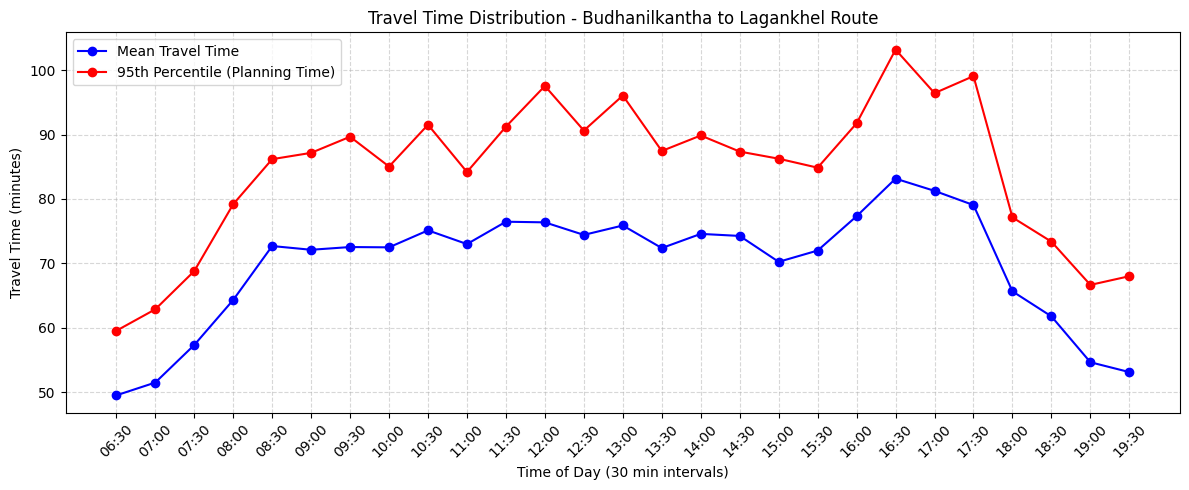

✅ Line graph saved at: C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Budhanilkantha-Lagankhel\PT and MTT vs Time of day.png


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# File path
file_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Budhanilkantha-Lagankhel.xlsx"
output_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Budhanilkantha-Lagankhel"
os.makedirs(output_path, exist_ok=True)

# Read Excel file (skip header rows if necessary)
df = pd.read_excel(file_path, header=None)

# Extract Mean Travel Time (column B, index 1) and 95th Percentile (column E, index 4)
# Data starts from row 3, which is index 2 in 0-based indexing
mean_travel_time = pd.to_numeric(df.iloc[2:, 1], errors='coerce')
percentile_95 = pd.to_numeric(df.iloc[2:, 4], errors='coerce')

# Create time intervals starting from 6:30 in 30-min intervals
start_time = datetime.strptime("06:30", "%H:%M")
time_labels = [(start_time + timedelta(minutes=30*i)).strftime('%H:%M') for i in range(len(mean_travel_time))]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(time_labels, mean_travel_time, marker='o', color='blue', label='Mean Travel Time')
plt.plot(time_labels, percentile_95, marker='o', color='red', label='95th Percentile (Planning Time)')

# Customize
plt.xticks(rotation=45)
plt.xlabel("Time of Day (30 min intervals)")
plt.ylabel("Travel Time (minutes)")
plt.title("Travel Time Distribution - Budhanilkantha to Lagankhel Route")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()

# Save figure
output_file = os.path.join(output_path, "PT and MTT vs Time of day.png")
plt.savefig(output_file, dpi=300)
plt.show()

print("✅ Line graph saved at:", output_file)


### PTI Heatmap – Full Route  
Budhanilkantha → Lagankhel

Planning Time Index by time of day (start of each 30-min interval)  
Higher values (darker colors) = greater travel time variability

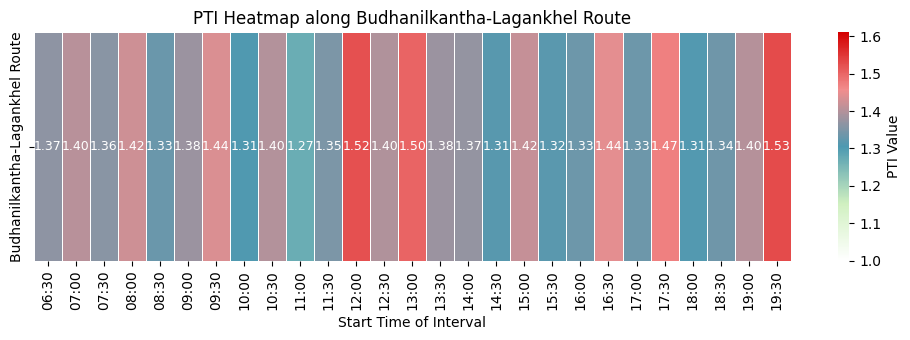

✅ PTI heatmap with start-time labels (e.g., 06:30) saved at: C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Budhanilkantha-Lagankhel\PTI_Heatmap_Budhanilkantha-Lagankhel Route_2.png


In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
from datetime import datetime, timedelta

# File paths
file_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Budhanilkantha-Lagankhel.xlsx"
output_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Budhanilkantha-Lagankhel"
os.makedirs(output_path, exist_ok=True)

# Read Excel file
df = pd.read_excel(file_path, header=None)

# Segment name
segment_name = str(df.iloc[0, 0]).strip()

# Extract and clean PTI values from I2 to I29
pti_values = df.iloc[2:29, 8].replace(r'[^0-9.]', '', regex=True)
pti_values = pd.to_numeric(pti_values, errors='coerce').fillna(0).tolist()

# Use only start time of each interval as the label (e.g., '06:00' instead of '06:00–06:30')
start_time = datetime.strptime("06:30", "%H:%M")
interval_labels = [
    (start_time + timedelta(minutes=30 * i)).strftime('%H:%M')
    for i in range(len(pti_values))
]

# Create a DataFrame with one row and all correct PTI values
pti_df = pd.DataFrame(
    [pti_values],
    index=["Budhanilkantha-Lagankhel Route"],
    columns=interval_labels
)

# Define custom colormap
color_map = LinearSegmentedColormap.from_list(
    "white_lightgreen_blue_darkerpink_red",
    ["#FFFFFF", "#D0F0C0", "#4C99B1", "#F28D8D", "#D40000"]
)

# Dynamic color scale range
vmin = 1
vmax = round(max(pti_values) + 0.03, 2) if max(pti_values) <= 2 else round(max(pti_values), 1)
vmax = max(vmax + 0.05, vmin)

# Plot with reduced horizontal scaling
plt.figure(figsize=(10, 3.5))
ax = sns.heatmap(pti_df, cmap=color_map, annot=True, fmt='.2f', linewidths=0.5,
                 vmin=vmin, vmax=vmax, annot_kws={"size": 9}, cbar_kws={'label': 'PTI Value'})

# Adjust ticks
ax.set_xticks([i + 0.5 for i in range(len(interval_labels))])
ax.set_xticklabels(interval_labels, rotation=90)
ax.set_yticklabels(["Budhanilkantha-Lagankhel Route"], rotation=90)

# Titles and layout
plt.xlabel("Start Time of Interval")
#plt.ylabel("Route", rotation=90)
plt.title("PTI Heatmap along Budhanilkantha-Lagankhel Route")
plt.tight_layout()

# Save
output_file = os.path.join(output_path, "PTI_Heatmap_Budhanilkantha-Lagankhel Route_2.png")
plt.savefig(output_file, dpi=300)
plt.show()

print("✅ PTI heatmap with start-time labels (e.g., 06:30) saved at:", output_file)


### Mean Travel Time & Planning Time Index vs Time of Day  
Budhanilkantha → Lagankhel Route

All segments compared:  
- Mean Travel Time (minutes)  
- Planning Time Index (PTI)  
across 30-minute intervals starting from 07:00

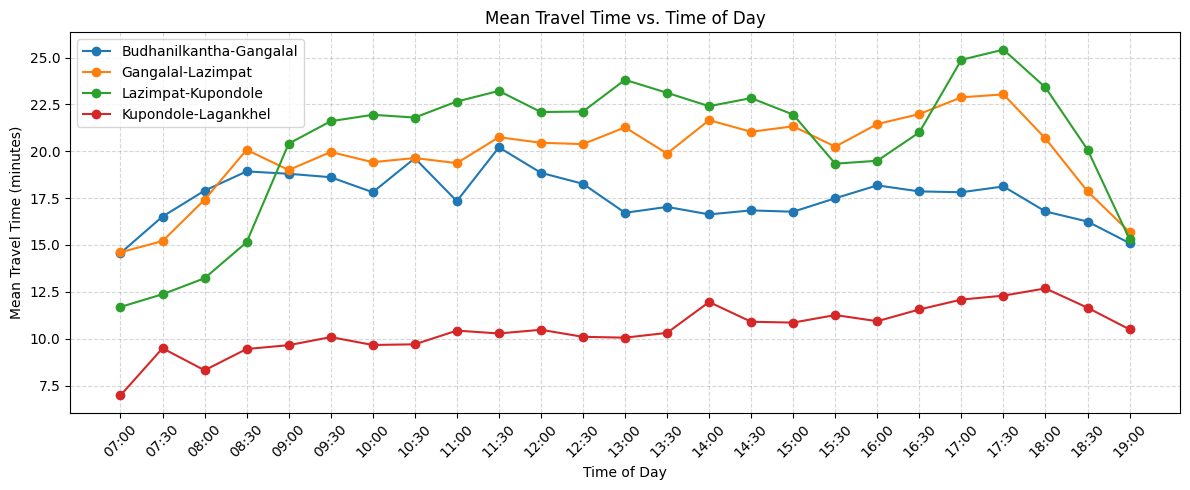

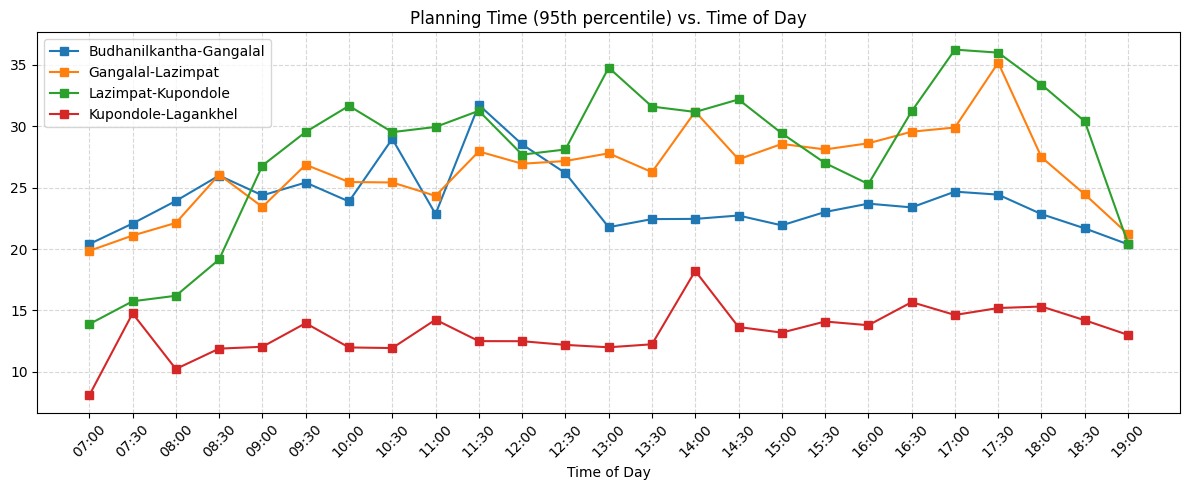

✅ Graphs saved successfully in: C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Budhanilkantha-Lagankhel\Combined Graphs


In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# List of Excel file paths
file_paths = [
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Budhanilkantha-Gangalal.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Gangalal-Lazimpat.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Lazimpat-Kupondole.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Kupondole-Lagankhel.xlsx"
]

# Output directory
output_dir = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Budhanilkantha-Lagankhel\Combined Graphs"
os.makedirs(output_dir, exist_ok=True)

# Dictionary to hold data
mean_travel_dict = {}
pti_dict = {}

# Define time intervals: 6:00 to 19:30 → 28 intervals at 30-min gap
start_time = datetime.strptime("07:00", "%H:%M")
intervals = [(start_time + timedelta(minutes=30 * i)).strftime('%H:%M') for i in range(25)]

# Read each file
for file_path in file_paths:
    df = pd.read_excel(file_path, header=None)

    segment_name = str(df.iloc[0, 0]).strip()

    # Mean Travel Time from B3:B30 (column 1, rows 2 to 29)
    mean_times = df.iloc[2:27, 1].replace(r'[^0-9.]', '', regex=True)
    mean_times = pd.to_numeric(mean_times, errors='coerce').fillna(0).tolist()
    mean_travel_dict[segment_name] = mean_times

    # PTI from H3:H30 (column 7, rows 2 to 29)
    pti_values = df.iloc[2:27, 7].replace(r'[^0-9.]', '', regex=True)
    pti_values = pd.to_numeric(pti_values, errors='coerce').fillna(0).tolist()
    pti_dict[segment_name] = pti_values

# Plot Mean Travel Time
plt.figure(figsize=(12, 5))
for segment, values in mean_travel_dict.items():
    plt.plot(intervals, values, marker='o', label=segment)
plt.title("Mean Travel Time vs. Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Mean Travel Time (minutes)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Mean_Travel_Time_vs_Time.png"), dpi=300)
plt.show()

# Plot PTI
plt.figure(figsize=(12, 5))
for segment, values in pti_dict.items():
    plt.plot(intervals, values, marker='s', label=segment)
plt.title("Planning Time (95th percentile) vs. Time of Day")
plt.xlabel("Time of Day")
#plt.ylabel("PTI")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "PT_vs_Time.png"), dpi=300)
plt.show()

print("✅ Graphs saved successfully in:", output_dir)


### Planning Time Index (PTI) Heatmap by Segment & Time of Day  
Budhanilkantha → Lagankhel Route

PTI values across all segments (rows) and 30-minute intervals (columns)  
Higher values (darker red) = greater travel time variability

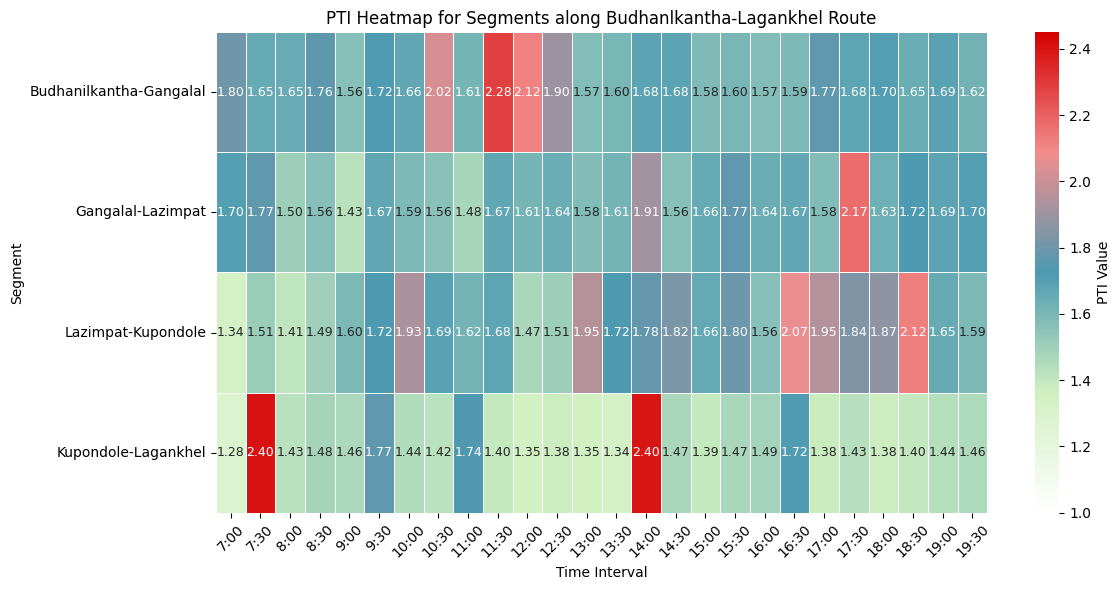

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# List of Excel file paths
file_paths = [
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Budhanilkantha-Gangalal.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Gangalal-Lazimpat.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Lazimpat-Kupondole.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Budhanilkantha-Lagankhel\Kupondole-Lagankhel.xlsx"
]

# Initialize an empty dictionary to store PTI values
pti_data = {}

# Read data from each file
for file in file_paths:
    df = pd.read_excel(file, header=None)
    segment_name = str(df.iloc[0, 0]).strip()
    pti_values = df.iloc[2:28, 8]
    pti_values_cleaned = pti_values.replace(r'[^0-9.]', '', regex=True)
    pti_values = pd.to_numeric(pti_values_cleaned, errors='coerce')
    pti_data[segment_name] = pti_values

# Convert to DataFrame and assign time intervals
pti_df = pd.DataFrame(pti_data)
time_intervals = [f"{hour}:{minute:02d}" for hour in range(7, 21) for minute in [0, 30]][:len(pti_df)]
pti_df.index = time_intervals
pti_df = pti_df.fillna(0)

# ✅ Custom colormap: white → light green → blue → dark pink → dark red
custom_cmap = LinearSegmentedColormap.from_list(
    "white_lightgreen_blue_darkerpink_red",
    ["#FFFFFF", "#D0F0C0", "#4C99B1", "#F28D8D", "#D40000"]
)

# Define vmin/vmax for consistency in color scale
vmin = 1
vmax = round(np.nanmax(pti_df.values) + 0.05, 2) if np.nanmax(pti_df.values) <= 2 else round(np.nanmax(pti_df.values), 1)
vmax = max(vmax + 0.05, vmin)

# Plot heatmap with consistent color scale and colorbar ticks like 1.1, 1.2, ...
plt.figure(figsize=(12, 6))
ax = sns.heatmap(pti_df.T, cmap=custom_cmap, annot=True, fmt='.2f', linewidths=0.5,
                 vmin=vmin, vmax=vmax, annot_kws={"size": 9}, cbar_kws={'label': 'PTI Value'})

# Set manual ticks for colorbar
tick_interval = 0.2
ticks = np.round(np.arange(vmin, vmax, tick_interval), 1)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks(ticks)
colorbar.set_ticklabels([f"{tick:.1f}" for tick in ticks])

# Labels and titles
plt.xlabel("Time Interval")
plt.ylabel("Segment")
plt.title("PTI Heatmap for Segments along Budhanlkantha-Lagankhel Route")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# ✅ Save the figure as PNG
output_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Budhanilkantha-Lagankhel\PTI_Heatmap.png"
plt.savefig(output_path, dpi=300)

plt.show()


## Lagankhel → Budhanilkantha (Route 1)

### Travel Time Variation by Time of Day  
Lagankhel → Budhanilkantha 

Mean travel time (blue) vs 95th percentile / Planning Time (red)  
30-minute intervals starting from 06:30

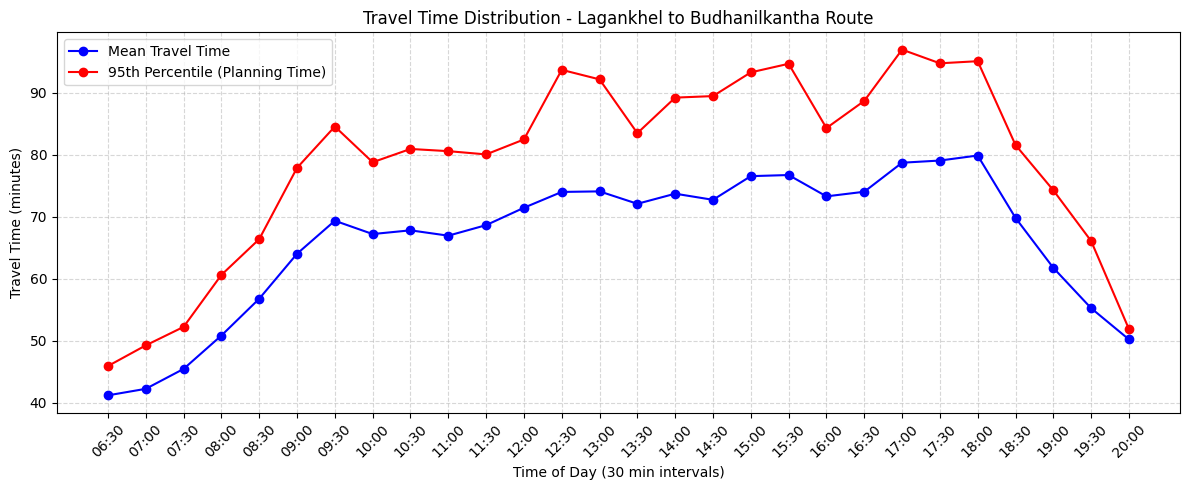

✅ Line graph saved at: C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Lagankhel-Budhanilkantha\PT and MTT vs Time of day.png


In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# File path
file_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Lagankhel-Budhanilkantha.xlsx"
output_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Lagankhel-Budhanilkantha"
os.makedirs(output_path, exist_ok=True)

# Read Excel file (skip header rows if necessary)
df = pd.read_excel(file_path, header=None)

# Extract Mean Travel Time (column B, index 1) and 95th Percentile (column E, index 4)
# Data starts from row 3, which is index 2 in 0-based indexing
mean_travel_time = pd.to_numeric(df.iloc[2:, 1], errors='coerce')
percentile_95 = pd.to_numeric(df.iloc[2:, 4], errors='coerce')

# Create time intervals starting from 6:30 in 30-min intervals
start_time = datetime.strptime("06:30", "%H:%M")
time_labels = [(start_time + timedelta(minutes=30*i)).strftime('%H:%M') for i in range(len(mean_travel_time))]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(time_labels, mean_travel_time, marker='o', color='blue', label='Mean Travel Time')
plt.plot(time_labels, percentile_95, marker='o', color='red', label='95th Percentile (Planning Time)')

# Customize
plt.xticks(rotation=45)
plt.xlabel("Time of Day (30 min intervals)")
plt.ylabel("Travel Time (minutes)")
plt.title("Travel Time Distribution - Lagankhel to Budhanilkantha Route")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()

# Save figure
output_file = os.path.join(output_path, "PT and MTT vs Time of day.png")
plt.savefig(output_file, dpi=300)
plt.show()

print("✅ Line graph saved at:", output_file)


### PTI Heatmap – Full Route  
Lagankhel → Budhanilkantha

Planning Time Index by time of day (start of each 30-min interval)  
Higher values (darker colors) = greater travel time variability

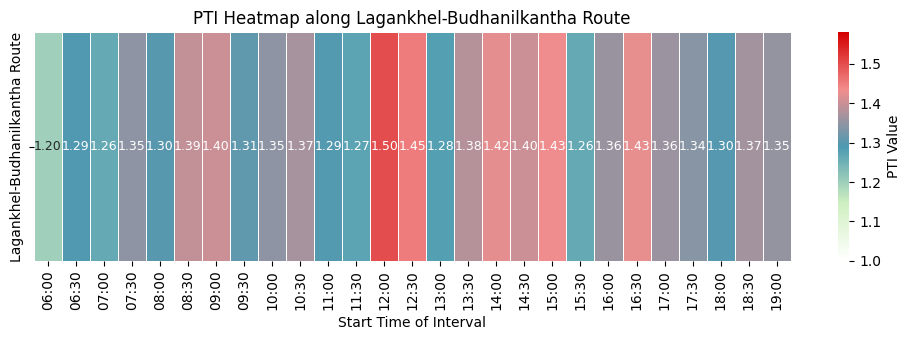

✅ PTI heatmap with start-time labels (e.g., 06:30) saved at: C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Lagankhel-Budhanilkantha\PTI_Heatmap_Lagankhel-Budhanilkantha Route_1.png


In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
from datetime import datetime, timedelta

# File paths
file_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Lagankhel-Budhanilkantha.xlsx"
output_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Lagankhel-Budhanilkantha"
os.makedirs(output_path, exist_ok=True)

# Read Excel file
df = pd.read_excel(file_path, header=None)

# Segment name
segment_name = str(df.iloc[0, 0]).strip()

# Extract and clean PTI values from I2 to I29
pti_values = df.iloc[2:29, 8].replace(r'[^0-9.]', '', regex=True)
pti_values = pd.to_numeric(pti_values, errors='coerce').fillna(0).tolist()

# Use only start time of each interval as the label (e.g., '06:00' instead of '06:00–06:30')
start_time = datetime.strptime("06:00", "%H:%M")
interval_labels = [
    (start_time + timedelta(minutes=30 * i)).strftime('%H:%M')
    for i in range(len(pti_values))
]

# Create a DataFrame with one row and all correct PTI values
pti_df = pd.DataFrame(
    [pti_values],
    index=["Lagankhel-Budhanilkantha Route"],
    columns=interval_labels
)

# Define custom colormap
color_map = LinearSegmentedColormap.from_list(
    "white_lightgreen_blue_darkerpink_red",
    ["#FFFFFF", "#D0F0C0", "#4C99B1", "#F28D8D", "#D40000"]
)

# Dynamic color scale range
vmin = 1
vmax = round(max(pti_values) + 0.03, 2) if max(pti_values) <= 2 else round(max(pti_values), 1)
vmax = max(vmax + 0.05, vmin)

# Plot with reduced horizontal scaling
plt.figure(figsize=(10, 3.5))
ax = sns.heatmap(pti_df, cmap=color_map, annot=True, fmt='.2f', linewidths=0.5,
                 vmin=vmin, vmax=vmax, annot_kws={"size": 9}, cbar_kws={'label': 'PTI Value'})

# Adjust ticks
ax.set_xticks([i + 0.5 for i in range(len(interval_labels))])
ax.set_xticklabels(interval_labels, rotation=90)
ax.set_yticklabels(["Lagankhel-Budhanilkantha Route"], rotation=90)

# Titles and layout
plt.xlabel("Start Time of Interval")
#plt.ylabel("Route", rotation=90)
plt.title("PTI Heatmap along Lagankhel-Budhanilkantha Route")
plt.tight_layout()

# Save
output_file = os.path.join(output_path, "PTI_Heatmap_Lagankhel-Budhanilkantha Route_1.png")
plt.savefig(output_file, dpi=300)
plt.show()

print("✅ PTI heatmap with start-time labels (e.g., 06:30) saved at:", output_file)


### Mean Travel Time & Planning Time Index vs Time of Day  
Lagankhel → Budhanilkantha Route

All segments compared:  
- Mean Travel Time (minutes)  
- Planning Time Index (PTI)  
across 30-minute intervals starting from 06:00

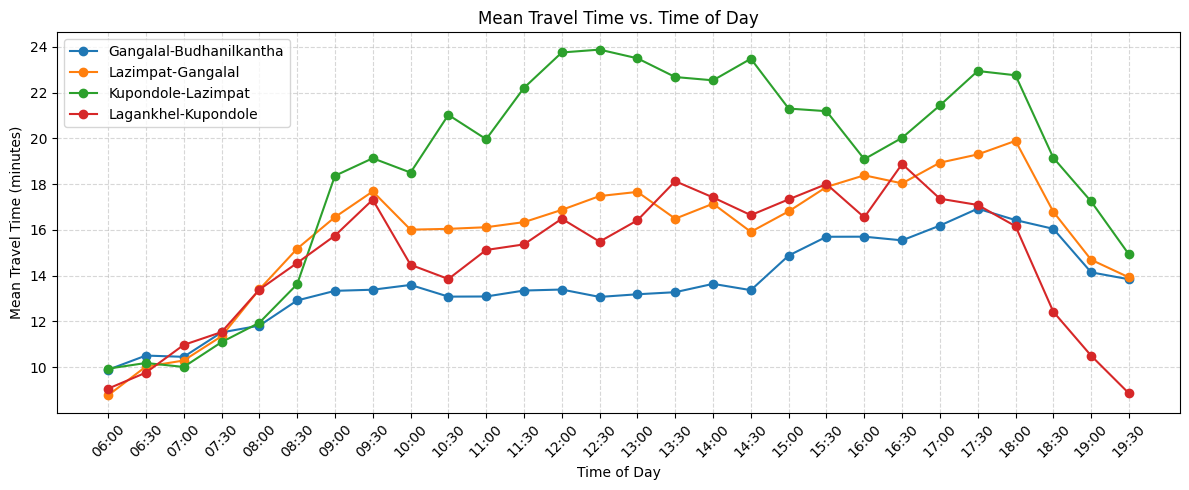

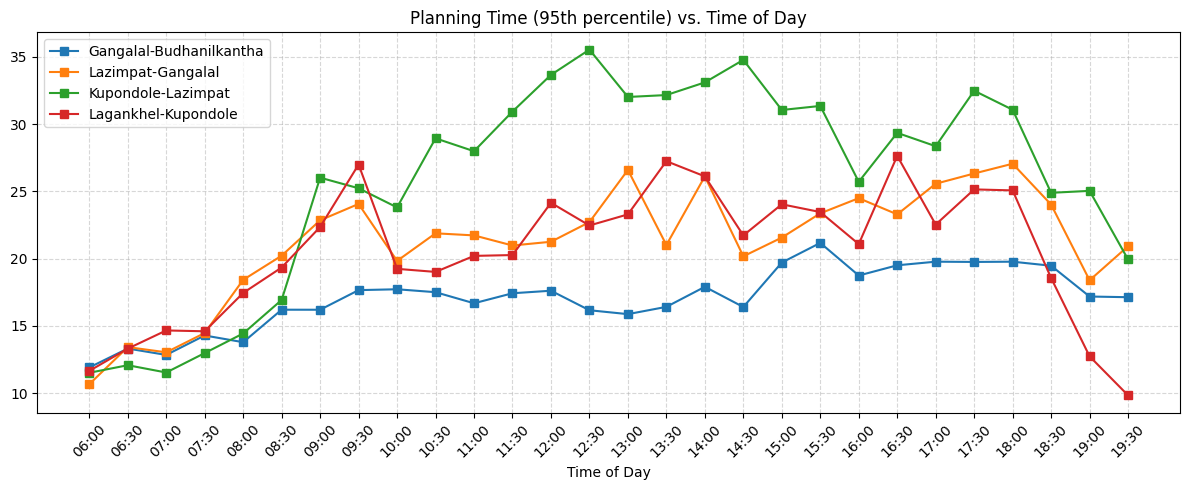

✅ Graphs saved successfully in: C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Lagankhel-Budhanilkantha\Combined Graphs


In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# List of Excel file paths
file_paths = [
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Gangalal-Budhanilkantha.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Lazimpat-Gangalal.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Kupondole-Lazimpat.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Lagankhel-Kupondole.xlsx"
]

# Output directory
output_dir = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Lagankhel-Budhanilkantha\Combined Graphs"
os.makedirs(output_dir, exist_ok=True)

# Dictionary to hold data
mean_travel_dict = {}
pti_dict = {}

# Define time intervals: 6:00 to 19:30 → 28 intervals at 30-min gap
start_time = datetime.strptime("06:00", "%H:%M")
intervals = [(start_time + timedelta(minutes=30 * i)).strftime('%H:%M') for i in range(28)]

# Read each file
for file_path in file_paths:
    df = pd.read_excel(file_path, header=None)

    segment_name = str(df.iloc[0, 0]).strip()

    # Mean Travel Time from B3:B30 (column 1, rows 2 to 29)
    mean_times = df.iloc[2:30, 1].replace(r'[^0-9.]', '', regex=True)
    mean_times = pd.to_numeric(mean_times, errors='coerce').fillna(0).tolist()
    mean_travel_dict[segment_name] = mean_times

    # PTI from H3:H30 (column 7, rows 2 to 29)
    pti_values = df.iloc[2:30, 7].replace(r'[^0-9.]', '', regex=True)
    pti_values = pd.to_numeric(pti_values, errors='coerce').fillna(0).tolist()
    pti_dict[segment_name] = pti_values

# Plot Mean Travel Time
plt.figure(figsize=(12, 5))
for segment, values in mean_travel_dict.items():
    plt.plot(intervals, values, marker='o', label=segment)
plt.title("Mean Travel Time vs. Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Mean Travel Time (minutes)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Mean_Travel_Time_vs_Time.png"), dpi=300)
plt.show()

# Plot PTI
plt.figure(figsize=(12, 5))
for segment, values in pti_dict.items():
    plt.plot(intervals, values, marker='s', label=segment)
plt.title("Planning Time (95th percentile) vs. Time of Day")
plt.xlabel("Time of Day")
#plt.ylabel("PTI")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "PT_vs_Time.png"), dpi=300)
plt.show()

print("✅ Graphs saved successfully in:", output_dir)

### Planning Time Index (PTI) Heatmap by Segment & Time of Day  
Lagankhel → Budhanilkantha Route

PTI values across all segments (rows) and 30-minute intervals (columns)  
Higher values (darker red) = greater travel time variability

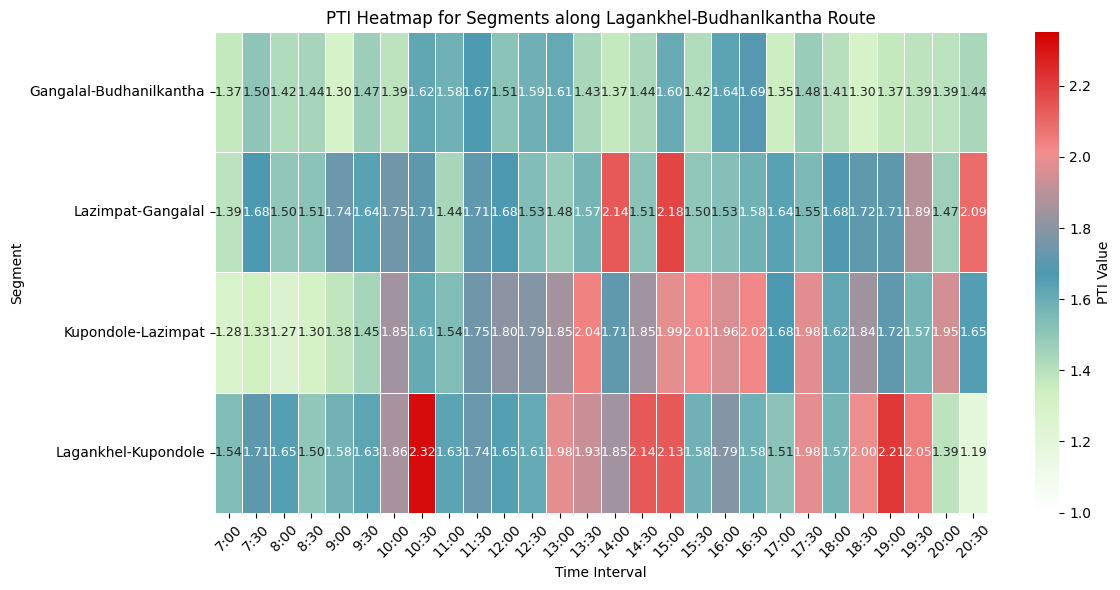

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# List of Excel file paths
# List of Excel file paths
file_paths = [
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Gangalal-Budhanilkantha.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Lazimpat-Gangalal.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Kupondole-Lazimpat.xlsx",
    r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Dataextraction\6.PTI_temporal_analysis\Lagankhel-Budhanilkantha\Lagankhel-Kupondole.xlsx"
]

# Initialize an empty dictionary to store PTI values
pti_data = {}

# Read data from each file
for file in file_paths:
    df = pd.read_excel(file, header=None)
    segment_name = str(df.iloc[0, 0]).strip()
    pti_values = df.iloc[2:30, 8]
    pti_values_cleaned = pti_values.replace(r'[^0-9.]', '', regex=True)
    pti_values = pd.to_numeric(pti_values_cleaned, errors='coerce')
    pti_data[segment_name] = pti_values

# Convert to DataFrame and assign time intervals
pti_df = pd.DataFrame(pti_data)
time_intervals = [f"{hour}:{minute:02d}" for hour in range(7, 21) for minute in [0, 30]][:len(pti_df)]
pti_df.index = time_intervals
pti_df = pti_df.fillna(0)

# ✅ Custom colormap: white → light green → blue → dark pink → dark red
custom_cmap = LinearSegmentedColormap.from_list(
    "white_lightgreen_blue_darkerpink_red",
    ["#FFFFFF", "#D0F0C0", "#4C99B1", "#F28D8D", "#D40000"]
)

# Define vmin/vmax for consistency in color scale
vmin = 1
vmax = round(np.nanmax(pti_df.values) + 0.05, 2) if np.nanmax(pti_df.values) <= 2 else round(np.nanmax(pti_df.values), 1)
vmax = max(vmax + 0.05, vmin)

# Plot heatmap with consistent color scale and colorbar ticks like 1.1, 1.2, ...
plt.figure(figsize=(12, 6))
ax = sns.heatmap(pti_df.T, cmap=custom_cmap, annot=True, fmt='.2f', linewidths=0.5,
                 vmin=vmin, vmax=vmax, annot_kws={"size": 9}, cbar_kws={'label': 'PTI Value'})

# Set manual ticks for colorbar
tick_interval = 0.2
ticks = np.round(np.arange(vmin, vmax, tick_interval), 1)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks(ticks)
colorbar.set_ticklabels([f"{tick:.1f}" for tick in ticks])

# Labels and titles
plt.xlabel("Time Interval")
plt.ylabel("Segment")
plt.title("PTI Heatmap for Segments along Lagankhel-Budhanlkantha Route")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# ✅ Save the figure as PNG
output_path = r"C:\Users\ACER\Desktop\PROJECT-FINAL YEAR\Datavisualization\Lagankhel-Budhanilkantha\PTI_Heatmap.png"
plt.savefig(output_path, dpi=300)

plt.show()
